# Contextual Quantum Neural Network for Stock Pricing

## Preprocessing of data 
Convert log-returns into probability distribution of qubit features

In [1]:
#imports
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
import seaborn as sns
import pennylane as qml
from itertools import product

In [2]:
VERBOSE = True

N_BINS = 2 # change from binary csv

df_binary = pd.read_csv("binary_stock_differences.csv")

print(df_binary.head())

   AAPL  AMZN  GOOG  MSFT
0     1     1     1     1
1     1     1     1     1
2     1     1     1     1
3     1     1     1     1
4     1     1     1     1


In [3]:

#split into windows
WINDOW_SIZE = 4 #time windows of 4

df = pd.DataFrame(columns=['context','window'])
    
for context, ticker in enumerate(df_binary.columns):
        
    stock_series = df_binary[ticker]
        
    # Slide a window across this one stock's time series
    # We stop (window_size - 1) from the end
    for i in range(len(stock_series) - WINDOW_SIZE + 1):
            
        # The full window (e.g., 4 log-returns)
        window = stock_series.iloc[i : i + WINDOW_SIZE]

        df.loc[len(df)] = [context, window.values]

print(df.head(15))

    context        window
0         0  [1, 1, 1, 1]
1         0  [1, 1, 1, 1]
2         0  [1, 1, 1, 1]
3         0  [1, 1, 1, 1]
4         0  [1, 1, 1, 1]
5         0  [1, 1, 1, 0]
6         0  [1, 1, 0, 1]
7         0  [1, 0, 1, 0]
8         0  [0, 1, 0, 0]
9         0  [1, 0, 0, 0]
10        0  [0, 0, 0, 0]
11        0  [0, 0, 0, 0]
12        0  [0, 0, 0, 0]
13        0  [0, 0, 0, 0]
14        0  [0, 0, 0, 0]


In [4]:
# split into train and test sets with stratification by context

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Stratify by context to ensure equal distribution in train and test sets
df_train = pd.DataFrame(columns=['context','window'])
df_val = pd.DataFrame(columns=['context','window'])
df_test = pd.DataFrame(columns=['context','window'])

# Group by context and split each group
for context_val in sorted(df['context'].unique()):
    context_df = df[df['context'] == context_val].reset_index(drop=True)
    
    # Split this context's data
    n_rows = len(context_df)
    train_index = int(n_rows * TRAIN_RATIO)
    val_index = int(n_rows * (TRAIN_RATIO + VAL_RATIO))
    
    # Add to train and test
    df_train = pd.concat([df_train, context_df.iloc[:train_index]], ignore_index=True)
    df_val = pd.concat([df_val, context_df.iloc[train_index:val_index]], ignore_index=True)
    df_test = pd.concat([df_test, context_df.iloc[val_index:]], ignore_index=True)

# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)


(4200, 2)
(900, 2)
(904, 2)


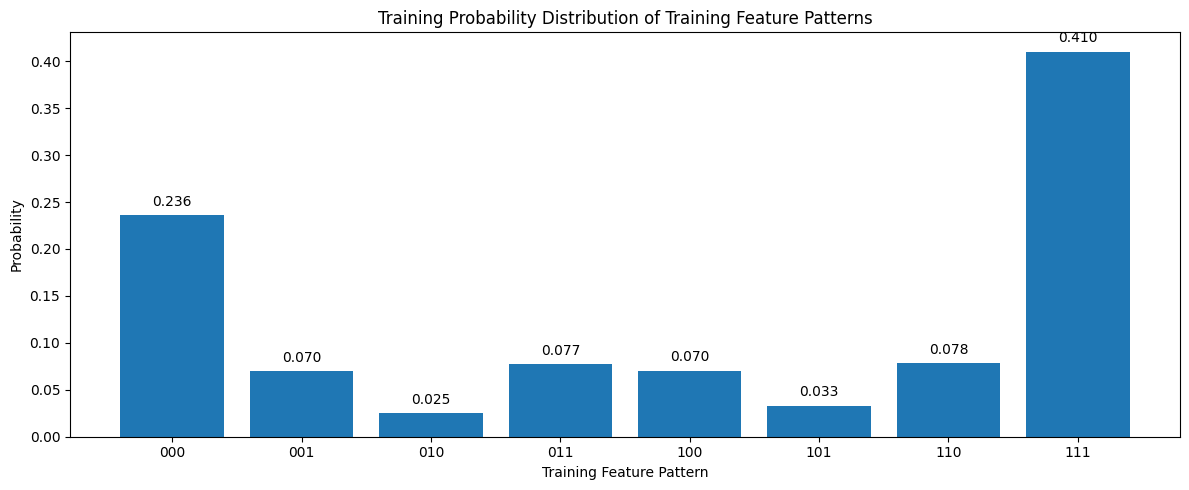

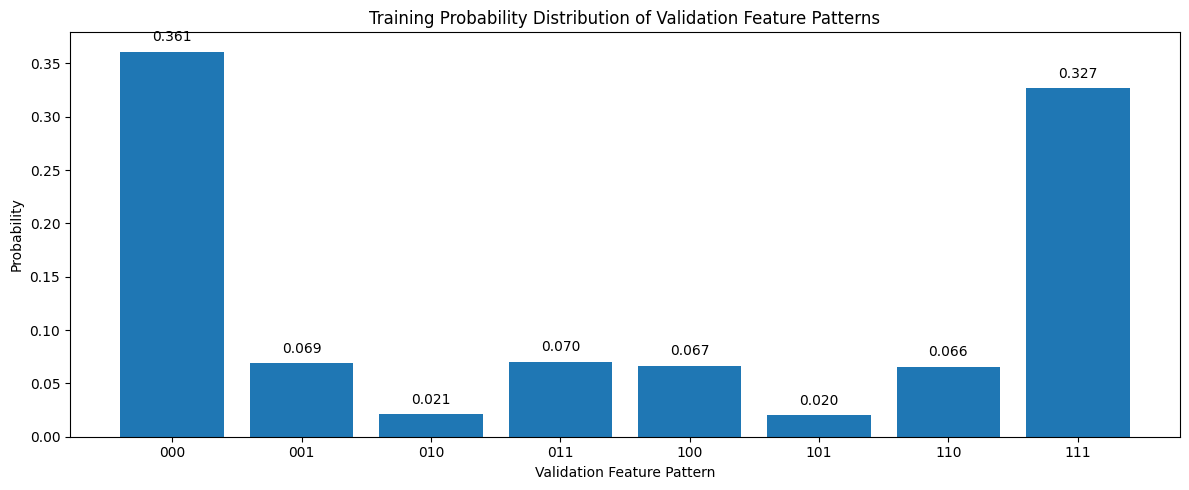

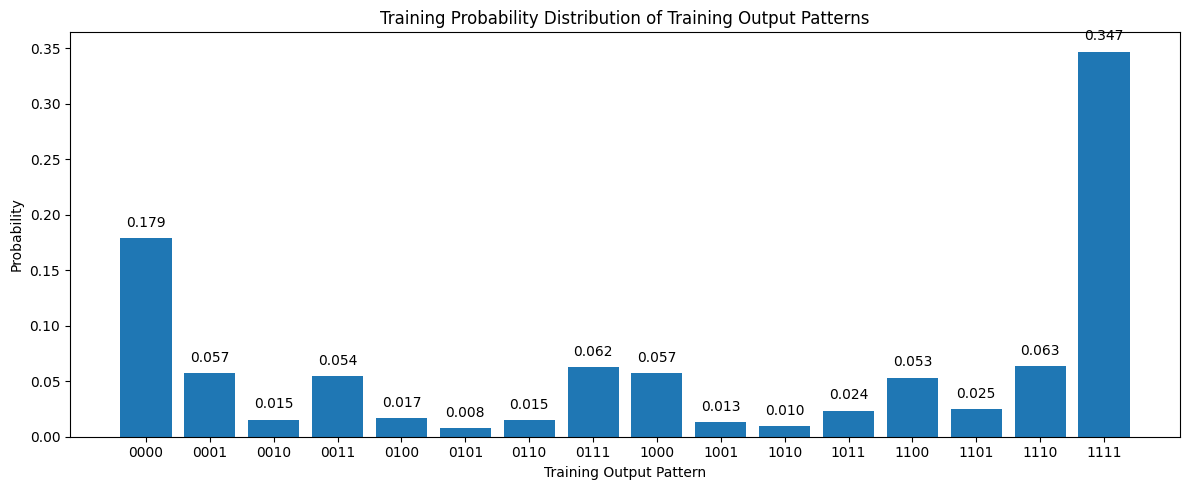

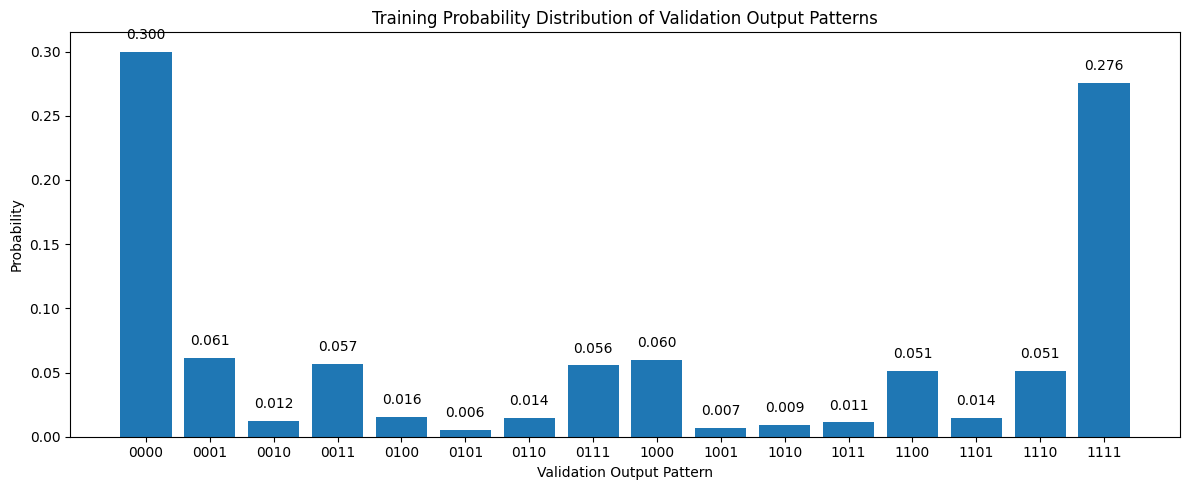

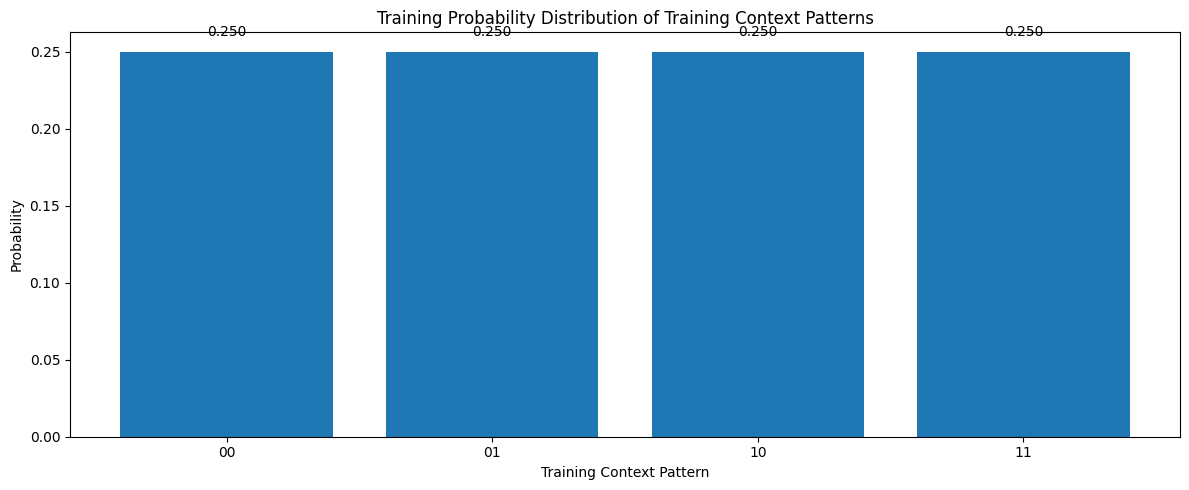

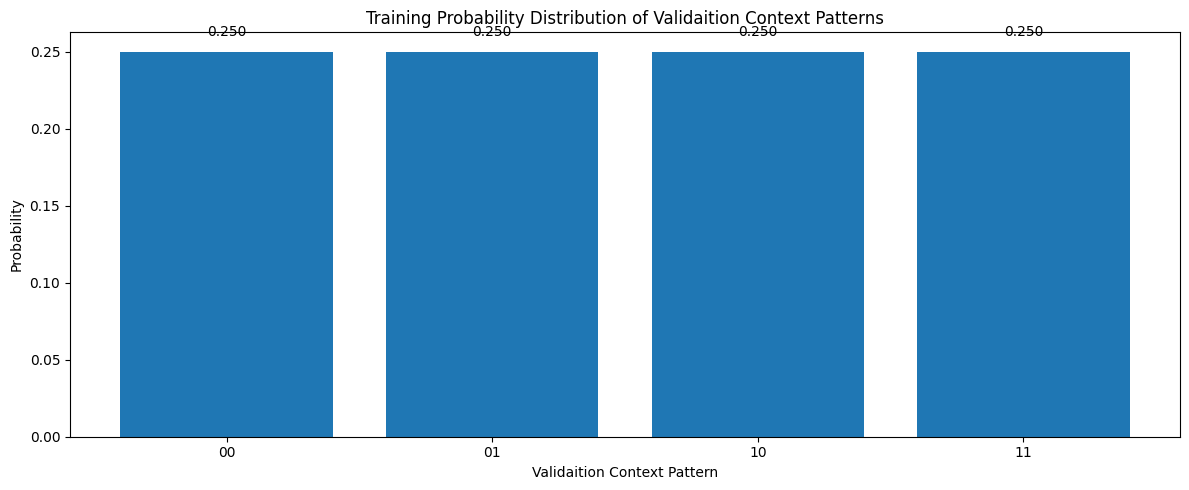

In [30]:
# Analyze global probability distributions (refactored with separate helpers)

probs_dict = {
    'train': {},
    'val': {}
}

def compute_distribution_vector(name, data_column, length):
    """Compute counts and probabilities for vector (window) data.

    - `data_column` is a Series/array of array-like windows.
    - `length` is the number of bits/features to consider from each window (truncate if longer).
    """
    patterns = np.array(list(product([0, 1], repeat=length)))
    pattern_strs = [''.join(map(str, p)) for p in patterns]

    # Stack windows into a 2D array and truncate to `length`
    data_arr = np.stack(pd.Series(data_column).apply(lambda x: np.asarray(x)[:length]))

    counts = np.array([np.sum(np.all(data_arr == p, axis=1)) for p in patterns])
    total = counts.sum()
    probs = counts / total if total > 0 else np.zeros_like(counts, dtype=float)

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.bar(pattern_strs, probs)
    plt.ylabel('Probability')
    plt.xlabel(name + ' Pattern')
    plt.title('Training Probability Distribution of ' + name + ' Patterns')
    for i, v in enumerate(probs):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    plt.tight_layout()
    plt.show()

    return {
        'patterns': patterns,
        'pattern_strs': pattern_strs,
        'counts': counts,
        'probs': torch.tensor(probs)
    }


def compute_distribution_scalar(name, data_column, n_classes, width=None):
    """Compute counts and probabilities for scalar (label) data.

    - `data_column` is a Series/array of integer labels (e.g., context indices).
    - `n_classes` is number of classes (e.g., 2**n_context).
    - `width` optionally controls the binary string width for pattern_strs.
    """
    if width is None:
        # infer minimal width to display binary strings
        width = int(np.ceil(np.log2(n_classes))) if n_classes > 1 else 1

    patterns = np.arange(n_classes)
    pattern_strs = [format(i, f'0{width}b') for i in patterns]

    data_arr = np.asarray(data_column).astype(int)
    counts = np.array([np.sum(data_arr == i) for i in patterns])
    total = counts.sum()
    probs = counts / total if total > 0 else np.zeros_like(counts, dtype=float)

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.bar(pattern_strs, probs)
    plt.ylabel('Probability')
    plt.xlabel(name + ' Pattern')
    plt.title('Training Probability Distribution of ' + name + ' Patterns')
    for i, v in enumerate(probs):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    plt.tight_layout()
    plt.show()

    return {
        'patterns': patterns,
        'pattern_strs': pattern_strs,
        'counts': counts,
        'probs': torch.tensor(probs)
    }

# 1) Feature patterns (first WINDOW_SIZE-1 entries)
n_features = WINDOW_SIZE - 1
probs_dict['train']['feature'] = compute_distribution_vector('Training Feature', df_train['window'], n_features)
probs_dict['val']['feature'] = compute_distribution_vector('Validation Feature', df_val['window'], n_features)

# 2) Output patterns (full WINDOW_SIZE entries)
n_window = WINDOW_SIZE
probs_dict['train']['output'] = compute_distribution_vector('Training Output', df_train['window'], n_window)
probs_dict['val']['output'] = compute_distribution_vector('Validation Output', df_val['window'], n_window)

# 3) Context distribution
n_context = int(np.log2(df_binary.shape[1]))
n_classes = 2 ** n_context
probs_dict['train']['context'] = compute_distribution_scalar('Training Context', df_train['context'], n_classes, width=n_context)
probs_dict['val']['context'] = compute_distribution_scalar('Validaition Context', df_val['context'], n_classes, width=n_context)


## Create state-preparation circuit to load input probability distribution into an approximate quantum state

In [10]:
# State preparation circuit (hardware-efficient ansatz)

def hardware_efficient_ansatz(params, wires, L):
    #Hadamard layer
    for wire in wires:
        qml.Hadamard(wire)

    for l in range(L):
        for i in range(len(wires)):
            qml.RY(params[l][i][0], wires=wires[i])
            qml.RZ(params[l][i][1], wires=wires[i])

        for i in range(len(wires)):
            qml.CNOT(wires=[wires[i], wires[(i + 1) % len(wires)]])

In [11]:
# function to train hardware-efficient-ansatz

L_SP = 2
N_EPOCHS_SP = 10000
LEARNING_RATE_SP = 0.1
INIT_PARAM_SCALE = 0.01
PATIENCE_SP = 200  # early-stopping patience (epochs)
MIN_DELTA_SP = 1e-8  # minimum improvement to reset patience
PRINT_INTERVAL = 50

def train_ansatz(target_probs, name, L=L_SP, lr=LEARNING_RATE_SP):

    num_wires = int(np.log2(len(target_probs)))

    dev_sp = qml.device("default.qubit", wires=num_wires)

    @qml.qnode(dev_sp, interface='torch', diff_method='spsa')
    def sp_circuit(params, num_wires):

        wires = range(num_wires)

        hardware_efficient_ansatz(params, wires, L)

        return qml.probs(wires=wires)

    # Initialize parameters as a NumPy array
    params_sp = nn.Parameter(torch.randn(L, num_wires, 2) * INIT_PARAM_SCALE)

    # Create SPSA optimizer
    opt_sp = torch.optim.Adam([params_sp], lr=lr)

    loss_fn_sp = nn.MSELoss()

    # Training loop using SPSA optimizer with early stopping
    losses_sp = []

    best_loss = float('inf')
    epochs_no_improve = 0
    # Keep a copy of best parameters (detached tensor)
    best_params_sp = params_sp.detach().clone()

    print("Beginning Ansatz Training for", name)

    for epoch in range(N_EPOCHS_SP):
        # Single SPSA update step

        y_pred = sp_circuit(params_sp, num_wires)

        loss = loss_fn_sp(y_pred, target_probs)

        loss.backward()

        opt_sp.step()

        opt_sp.zero_grad()

        loss_value = loss.item()
        losses_sp.append(loss_value)

        # Check improvement for early stopping
        if loss_value < best_loss - MIN_DELTA_SP:
            best_loss = loss_value
            epochs_no_improve = 0
            best_params_sp = params_sp.detach().clone()
        else:
            epochs_no_improve += 1

        # Print progress
        if (epoch + 1) % PRINT_INTERVAL == 0 or epoch == N_EPOCHS_SP - 1:
            print(f"Epoch {epoch+1} - MSE Loss: {loss_value:.9f} - Best: {best_loss:.9f} - Stalled: {epochs_no_improve}/{PATIENCE_SP}")

        # Early stopping check
        if epochs_no_improve >= PATIENCE_SP:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {PATIENCE_SP} epochs).")
            break

    target_out_np = target_probs.detach().numpy()
    final_out_np = sp_circuit(best_params_sp, num_wires).detach().numpy()

    # Plot training loss
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(losses_sp) + 1), losses_sp)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('State Preparation for ' + name)
    plt.grid(True)
    plt.show()

    patterns = np.array(list(product([0, 1], repeat=num_wires)))
    pattern_strs = [''.join(map(str, p)) for p in patterns]

    #Plot target probabilities and predicted probabilites
    x = np.arange(len(pattern_strs))
    width = 0.35  # Width of the bars

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, target_out_np, width, label='Target')
    plt.bar(x + width/2, final_out_np, width, label='Predicted')

    plt.ylabel('Probability')
    plt.xlabel('Feature Pattern')
    plt.title('Predicted vs. Target Probability Distribution of ' + name + ' Patterns')
    plt.xticks(x, pattern_strs)
    plt.legend()

    # Add probability values on top of bars
    for i, (v1, v2) in enumerate(zip(target_out_np, final_out_np)):
        plt.text(i - width/2, v1 + 0.01, f'{v1:.3f}', ha='center')
        plt.text(i + width/2, v2 + 0.01, f'{v2:.3f}', ha='center')

    plt.tight_layout()
    plt.show()

    print(qml.draw(sp_circuit)(best_params_sp, num_wires))    

    return best_params_sp


In [ ]:
# train ansatz for all elements of probs_dict

sp_params = {
    'train': nn.ParameterDict(),
    'val': nn.ParameterDict()
}

L_list = {
    'feature': 3,
    'output': 4,
    'context': 3}
lr_list = {
    'feature': 0.05,
    'output': 0.01,
    'context': 0.1
}

Beginning Ansatz Training for Training feature
Epoch 50 - MSE Loss: 0.000129957 - Best: 0.000129957 - Stalled: 0/200
Epoch 50 - MSE Loss: 0.000129957 - Best: 0.000129957 - Stalled: 0/200
Epoch 100 - MSE Loss: 0.000008563 - Best: 0.000008563 - Stalled: 0/200
Epoch 100 - MSE Loss: 0.000008563 - Best: 0.000008563 - Stalled: 0/200
Epoch 150 - MSE Loss: 0.000000497 - Best: 0.000000497 - Stalled: 0/200
Epoch 150 - MSE Loss: 0.000000497 - Best: 0.000000497 - Stalled: 0/200
Epoch 200 - MSE Loss: 0.000000127 - Best: 0.000000127 - Stalled: 0/200
Epoch 200 - MSE Loss: 0.000000127 - Best: 0.000000127 - Stalled: 0/200
Epoch 250 - MSE Loss: 0.000000136 - Best: 0.000000116 - Stalled: 41/200
Epoch 250 - MSE Loss: 0.000000136 - Best: 0.000000116 - Stalled: 41/200
Epoch 300 - MSE Loss: 0.000000016 - Best: 0.000000022 - Stalled: 19/200
Epoch 300 - MSE Loss: 0.000000016 - Best: 0.000000022 - Stalled: 19/200
Epoch 350 - MSE Loss: 0.000000003 - Best: 0.000000011 - Stalled: 31/200
Epoch 350 - MSE Loss: 0.000

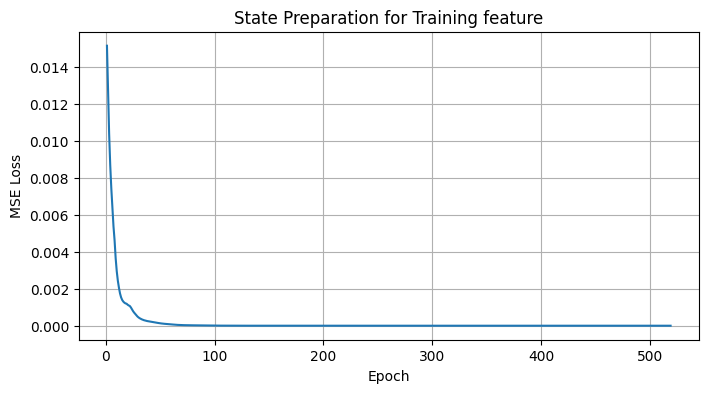

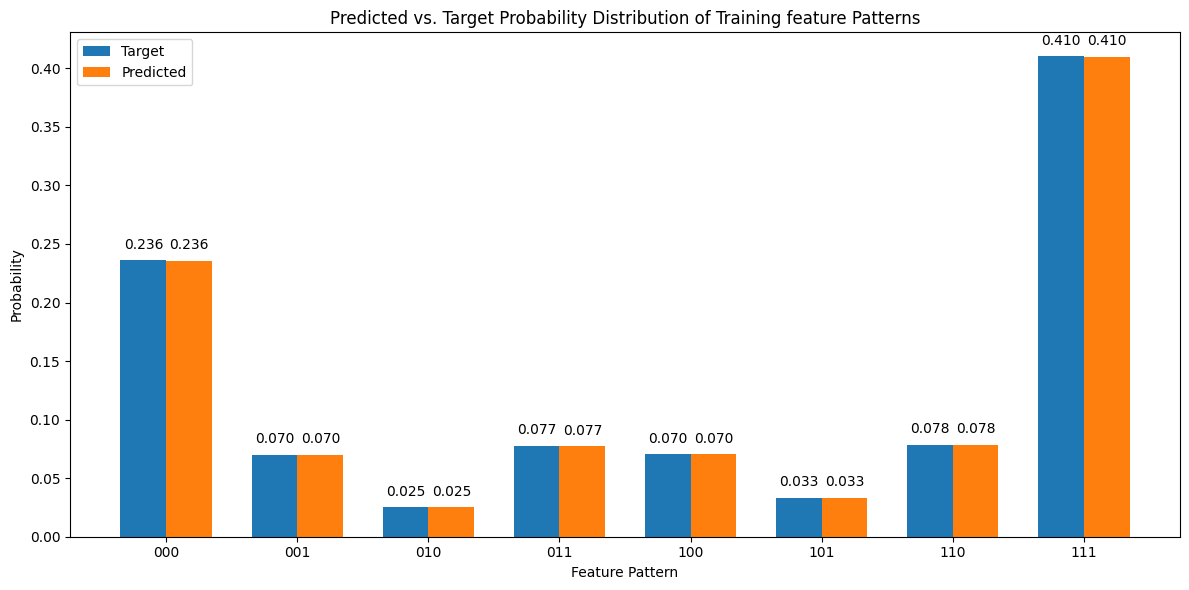

0: ──H──RY(0.07)───RZ(0.34)─╭●────╭X──RY(-0.53)──RZ(-0.04)─╭●────╭X──RY(-0.13)──RZ(0.33)──╭●─── ···
1: ──H──RY(-0.51)──RZ(0.32)─╰X─╭●─│───RY(0.16)───RZ(-0.50)─╰X─╭●─│───RY(0.02)───RZ(0.32)──╰X─╭● ···
2: ──H──RY(-0.28)──RZ(0.03)────╰X─╰●──RY(0.22)───RZ(0.53)─────╰X─╰●──RY(-0.09)──RZ(-0.26)────╰X ···

0: ··· ─╭X─┤ ╭Probs
1: ··· ─│──┤ ├Probs
2: ··· ─╰●─┤ ╰Probs
Beginning Ansatz Training for Training output
Epoch 50 - MSE Loss: 0.002410097 - Best: 0.002410097 - Stalled: 0/200
Epoch 50 - MSE Loss: 0.002410097 - Best: 0.002410097 - Stalled: 0/200
Epoch 100 - MSE Loss: 0.000484916 - Best: 0.000484916 - Stalled: 0/200
Epoch 100 - MSE Loss: 0.000484916 - Best: 0.000484916 - Stalled: 0/200
Epoch 150 - MSE Loss: 0.000169191 - Best: 0.000169191 - Stalled: 0/200
Epoch 150 - MSE Loss: 0.000169191 - Best: 0.000169191 - Stalled: 0/200
Epoch 200 - MSE Loss: 0.000094809 - Best: 0.000094809 - Stalled: 0/200
Epoch 200 - MSE Loss: 0.000094809 - Best: 0.000094809 - Stalled: 0/200
Epoch 250 - MSE Loss: 0.000

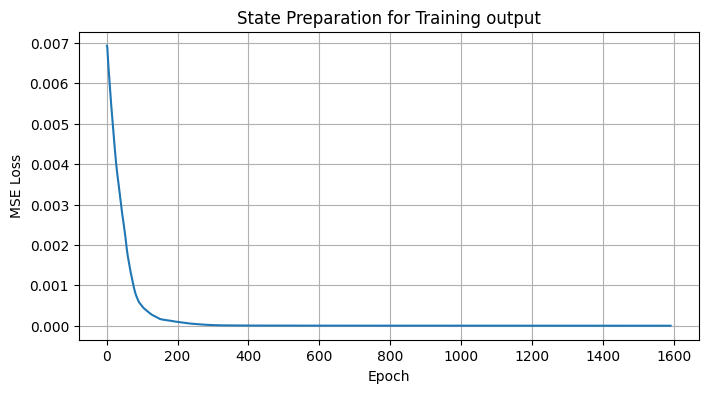

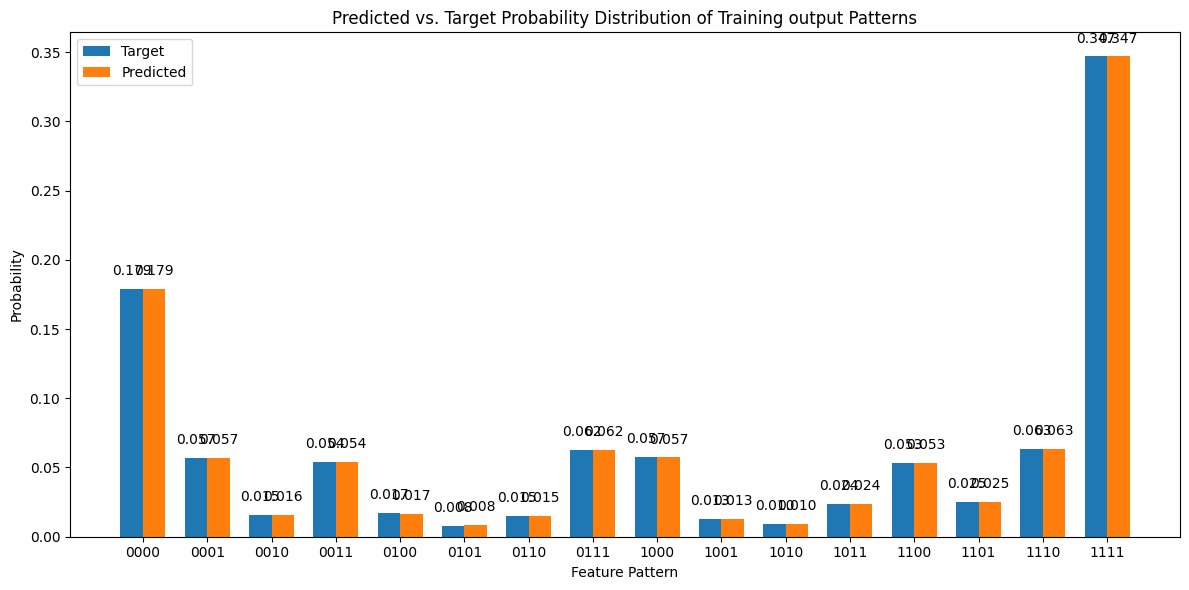

0: ──H──RY(0.04)───RZ(0.01)──╭●───────╭X──RY(-0.26)──RZ(-0.05)─╭●───────╭X──RY(-0.37)──RZ(0.08)─ ···
1: ──H──RY(-0.20)──RZ(0.10)──╰X─╭●────│───RY(0.07)───RZ(-0.11)─╰X─╭●────│───RY(0.07)───RZ(-0.08) ···
2: ──H──RY(0.09)───RZ(0.04)─────╰X─╭●─│───RY(-0.43)──RZ(0.05)─────╰X─╭●─│───RY(0.08)───RZ(-0.04) ···
3: ──H──RY(0.08)───RZ(-0.05)───────╰X─╰●──RY(0.11)───RZ(0.00)────────╰X─╰●──RY(-0.11)──RZ(0.04)─ ···

0: ··· ─╭●───────╭X──RY(-0.03)──RZ(-0.12)─╭●───────╭X─┤ ╭Probs
1: ··· ─╰X─╭●────│───RY(0.09)───RZ(-0.07)─╰X─╭●────│──┤ ├Probs
2: ··· ────╰X─╭●─│───RY(-0.55)──RZ(0.11)─────╰X─╭●─│──┤ ├Probs
3: ··· ───────╰X─╰●──RY(-0.54)──RZ(0.00)────────╰X─╰●─┤ ╰Probs
Beginning Ansatz Training for Training context
Epoch 50 - MSE Loss: 0.001279596 - Best: 0.000057751 - Stalled: 49/200
Epoch 50 - MSE Loss: 0.001279596 - Best: 0.000057751 - Stalled: 49/200
Epoch 100 - MSE Loss: 0.000565574 - Best: 0.000007982 - Stalled: 24/200
Epoch 100 - MSE Loss: 0.000565574 - Best: 0.000007982 - Stalled: 24/200
Epoch 150 

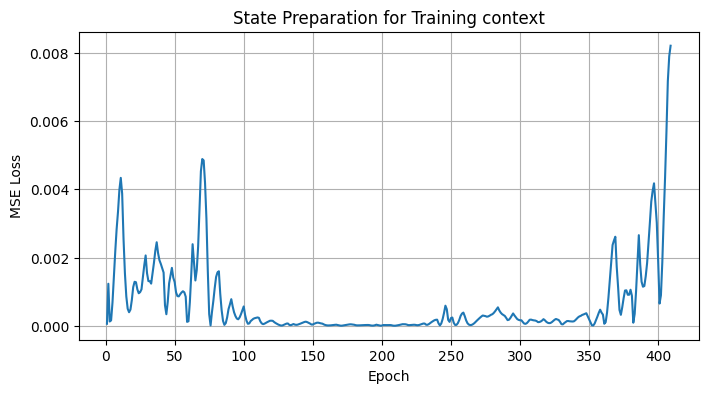

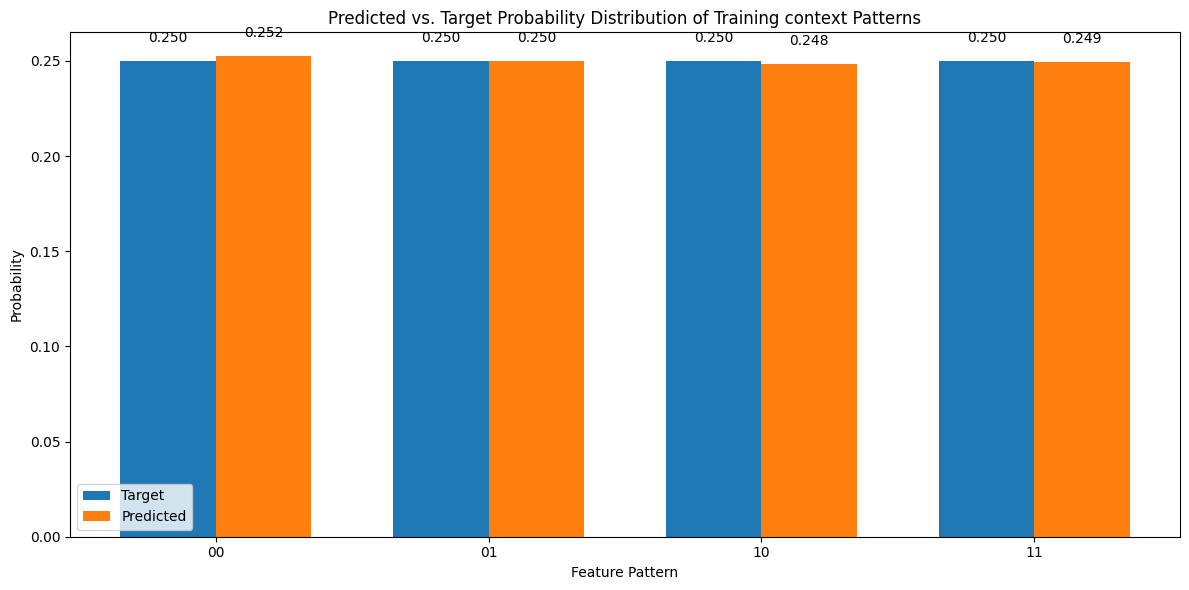

0: ──H──RY(-0.63)──RZ(1.76)──╭●─╭X──RY(1.34)──RZ(0.21)─╭●─╭X─┤ ╭Probs
1: ──H──RY(0.29)───RZ(-1.06)─╰X─╰●──RY(0.86)──RZ(0.37)─╰X─╰●─┤ ╰Probs
Beginning Ansatz Training for Validation feature
Epoch 50 - MSE Loss: 0.000351560 - Best: 0.000351560 - Stalled: 0/200
Epoch 50 - MSE Loss: 0.000351560 - Best: 0.000351560 - Stalled: 0/200
Epoch 100 - MSE Loss: 0.000012092 - Best: 0.000011417 - Stalled: 2/200
Epoch 100 - MSE Loss: 0.000012092 - Best: 0.000011417 - Stalled: 2/200
Epoch 150 - MSE Loss: 0.000003511 - Best: 0.000003511 - Stalled: 0/200
Epoch 150 - MSE Loss: 0.000003511 - Best: 0.000003511 - Stalled: 0/200
Epoch 200 - MSE Loss: 0.000002129 - Best: 0.000001993 - Stalled: 31/200
Epoch 200 - MSE Loss: 0.000002129 - Best: 0.000001993 - Stalled: 31/200
Epoch 250 - MSE Loss: 0.000001369 - Best: 0.000000855 - Stalled: 9/200
Epoch 250 - MSE Loss: 0.000001369 - Best: 0.000000855 - Stalled: 9/200
Epoch 300 - MSE Loss: 0.000000111 - Best: 0.000000092 - Stalled: 12/200
Epoch 300 - MSE Loss: 0.00000

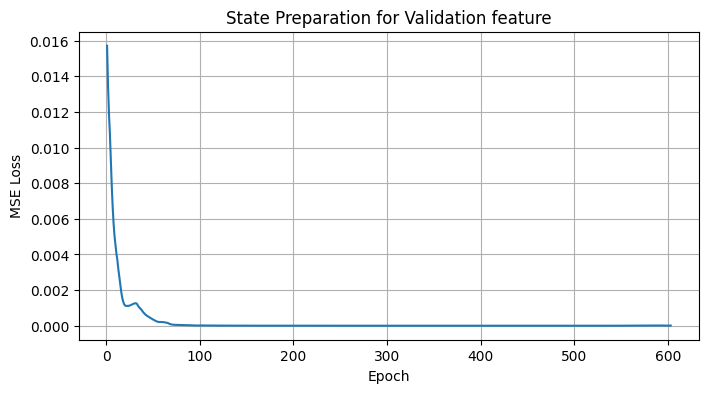

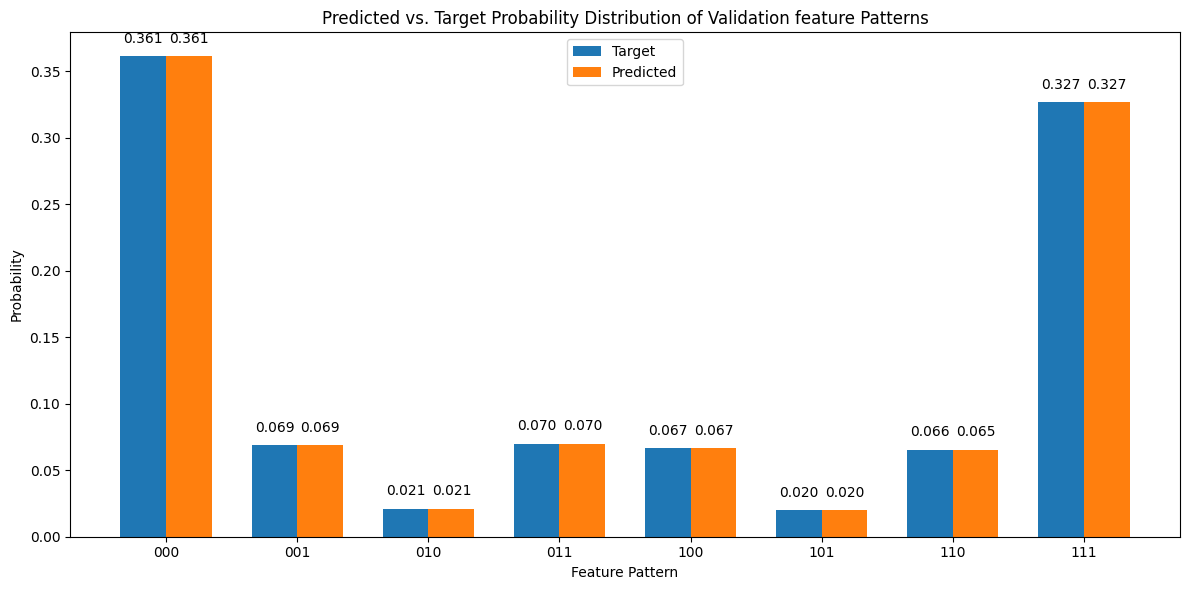

0: ──H──RY(-0.01)──RZ(0.06)──╭●────╭X──RY(-0.51)──RZ(-0.13)─╭●────╭X──RY(-0.27)──RZ(0.50)──╭●─── ···
1: ──H──RY(-0.12)──RZ(0.07)──╰X─╭●─│───RY(-0.01)──RZ(0.58)──╰X─╭●─│───RY(-0.04)──RZ(-0.44)─╰X─╭● ···
2: ──H──RY(-0.29)──RZ(-0.06)────╰X─╰●──RY(0.02)───RZ(0.07)─────╰X─╰●──RY(-0.74)──RZ(0.34)─────╰X ···

0: ··· ─╭X─┤ ╭Probs
1: ··· ─│──┤ ├Probs
2: ··· ─╰●─┤ ╰Probs
Beginning Ansatz Training for Validation output
Epoch 50 - MSE Loss: 0.002810479 - Best: 0.002810479 - Stalled: 0/200
Epoch 50 - MSE Loss: 0.002810479 - Best: 0.002810479 - Stalled: 0/200
Epoch 100 - MSE Loss: 0.000854035 - Best: 0.000854035 - Stalled: 0/200
Epoch 100 - MSE Loss: 0.000854035 - Best: 0.000854035 - Stalled: 0/200
Epoch 150 - MSE Loss: 0.000251391 - Best: 0.000251391 - Stalled: 0/200
Epoch 150 - MSE Loss: 0.000251391 - Best: 0.000251391 - Stalled: 0/200
Epoch 200 - MSE Loss: 0.000081519 - Best: 0.000081519 - Stalled: 0/200
Epoch 200 - MSE Loss: 0.000081519 - Best: 0.000081519 - Stalled: 0/200
Epoch 250 - MSE Loss: 

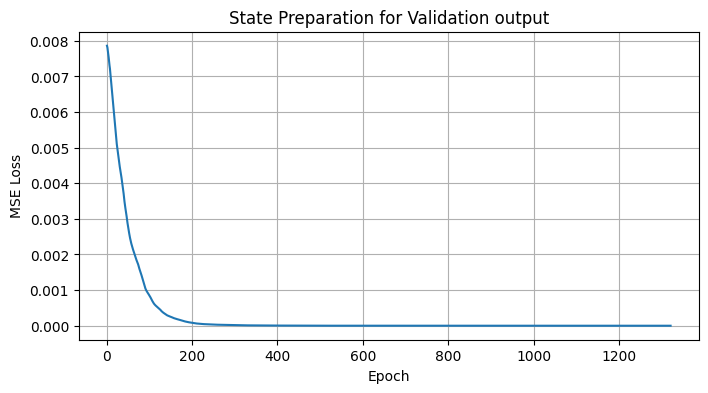

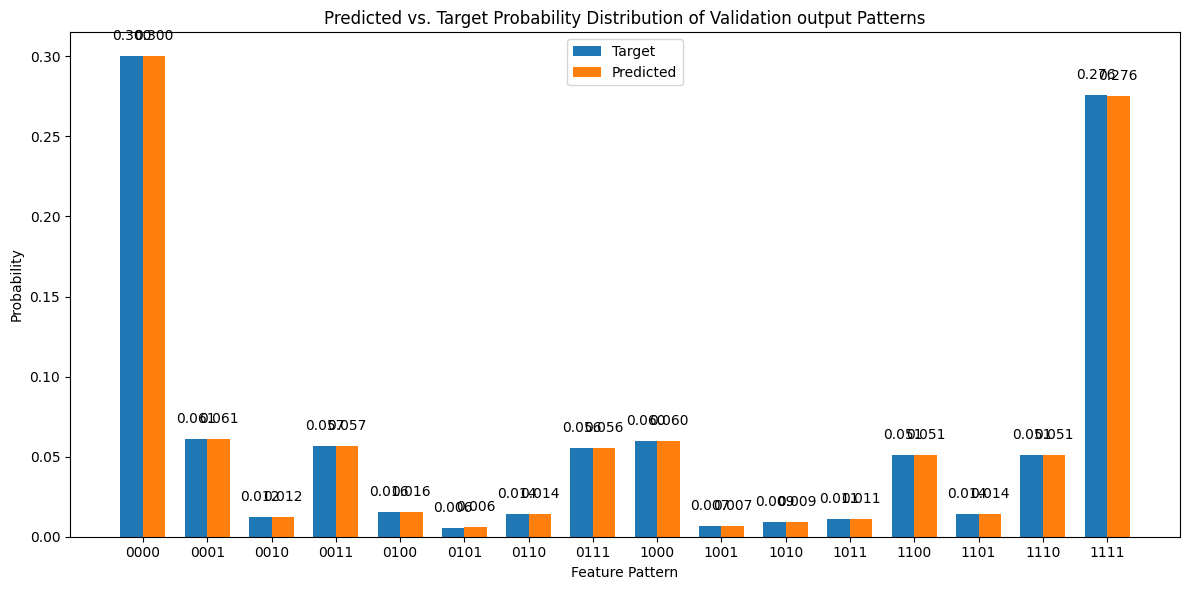

0: ──H──RY(0.00)───RZ(-0.04)─╭●───────╭X──RY(-0.32)──RZ(-0.04)─╭●───────╭X──RY(-0.44)──RZ(-0.08) ···
1: ──H──RY(-0.22)──RZ(-0.01)─╰X─╭●────│───RY(-0.00)──RZ(0.10)──╰X─╭●────│───RY(-0.06)──RZ(-0.00) ···
2: ──H──RY(-0.00)──RZ(0.05)─────╰X─╭●─│───RY(-0.39)──RZ(0.09)─────╰X─╭●─│───RY(-0.05)──RZ(-0.01) ···
3: ──H──RY(-0.01)──RZ(0.05)────────╰X─╰●──RY(-0.07)──RZ(-0.07)───────╰X─╰●──RY(-0.11)──RZ(0.08)─ ···

0: ··· ─╭●───────╭X──RY(-0.07)──RZ(-0.04)─╭●───────╭X─┤ ╭Probs
1: ··· ─╰X─╭●────│───RY(0.05)───RZ(0.10)──╰X─╭●────│──┤ ├Probs
2: ··· ────╰X─╭●─│───RY(-0.66)──RZ(-0.03)────╰X─╭●─│──┤ ├Probs
3: ··· ───────╰X─╰●──RY(-0.62)──RZ(0.06)────────╰X─╰●─┤ ╰Probs
Beginning Ansatz Training for Validation context
Epoch 50 - MSE Loss: 0.000564136 - Best: 0.000008280 - Stalled: 49/200
Epoch 50 - MSE Loss: 0.000564136 - Best: 0.000008280 - Stalled: 49/200
Epoch 100 - MSE Loss: 0.000082971 - Best: 0.000008280 - Stalled: 99/200
Epoch 100 - MSE Loss: 0.000082971 - Best: 0.000008280 - Stalled: 99/200
Epoch 15

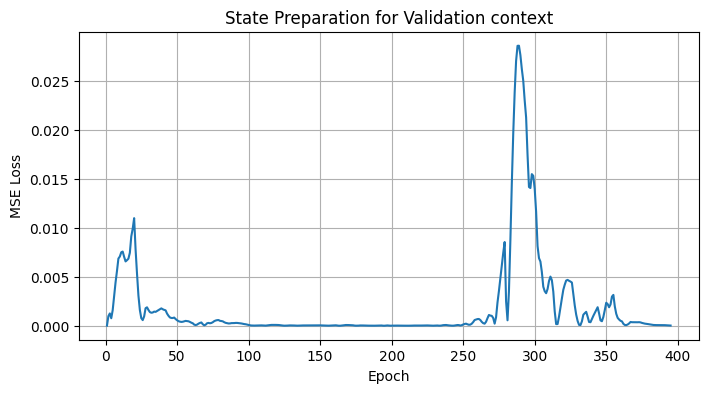

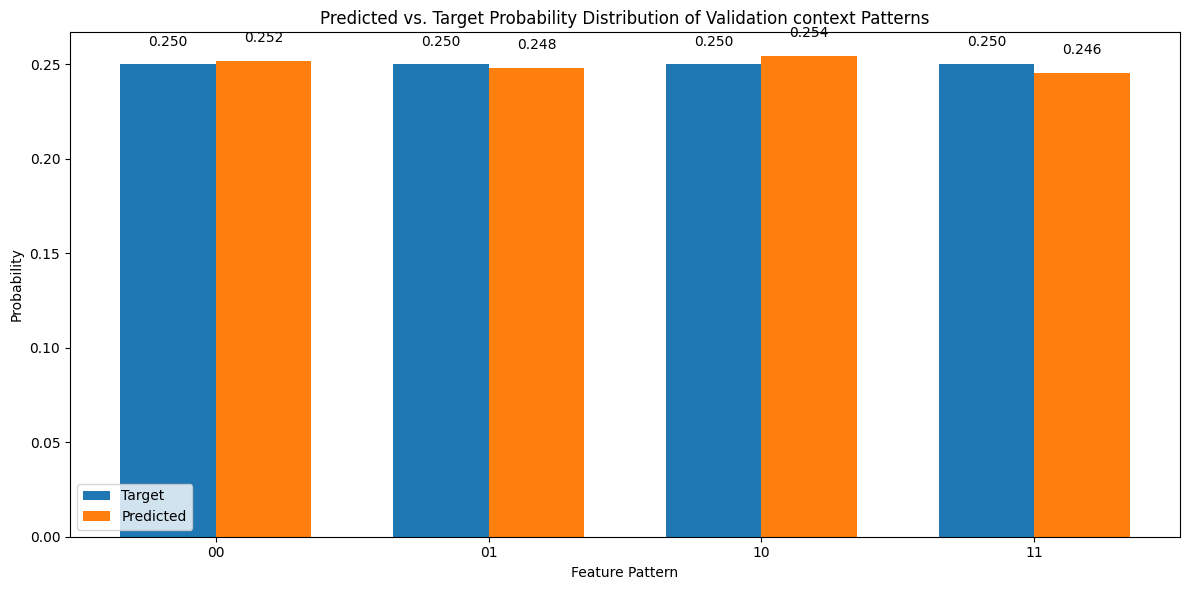

0: ──H──RY(-0.56)──RZ(1.72)─╭●─╭X──RY(-0.91)──RZ(-0.09)─╭●─╭X─┤ ╭Probs
1: ──H──RY(-0.09)──RZ(0.88)─╰X─╰●──RY(-0.38)──RZ(-0.05)─╰X─╰●─┤ ╰Probs


In [31]:
# Train ansatz for each probability distribution in probs_dict
for key, target_probs in probs_dict['train'].items():
    sp_params['train'][key] = train_ansatz(target_probs['probs'], 'Training ' + key, L=L_list[key], lr=lr_list[key])
for key, target_probs in probs_dict['val'].items():
    sp_params['val'][key] = train_ansatz(target_probs['probs'], 'Validation ' + key, L=L_list[key], lr=lr_list[key])

#save parameters so that re-training is not necessary
torch.save(sp_params, 'sp_params.pth')

## Create Prediction Circuit (Quantum Multi-Task Learning)

In [ ]:
#Build the circuit

# 0-1: context qubits
# 2-4: input qubits
# 5: output qubit
N_CONTEXT_WIRES = n_context  # Number of qubits needed to represent stocks
N_OUTPUT_WIRES = int(np.log2(N_BINS))
N_INPUT_WIRES = WINDOW_SIZE - N_OUTPUT_WIRES
N_TARGET_WIRES = N_INPUT_WIRES + N_OUTPUT_WIRES
N_TOTAL_WIRES = N_CONTEXT_WIRES + N_INPUT_WIRES + N_OUTPUT_WIRES + N_TARGET_WIRES + 1 #ancillary qubit

N_LAYERS = 2

input_wires = list(range(N_INPUT_WIRES))
output_wires = list(range(N_INPUT_WIRES, N_INPUT_WIRES + N_OUTPUT_WIRES))
context_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES, N_INPUT_WIRES + N_OUTPUT_WIRES + N_CONTEXT_WIRES))
target_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES + N_CONTEXT_WIRES, N_TOTAL_WIRES - 1))
ancillary_wire = N_TOTAL_WIRES - 1
comp_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES))

#load params
sp_params = torch.load('sp_params.pth', weights_only=False)

# Define device using simulator for training
dev = qml.device("default.qubit", wires=N_TOTAL_WIRES)

# layer for both either the shared or specify ansatz (input is just trainable parameters)
def U_ss(params):
    """A single (L=1) ansatz layer (Rotations + CNOTs)."""
    # 1. Trainable Rotations
    for i, wire in enumerate(comp_wires):
        qml.RY(params[i][0], wires=wire)
        qml.RZ(params[i][1], wires=wire)
    
    # 2. Entangling "Ring"
    for i in range(len(comp_wires)):
        qml.CNOT(wires=[comp_wires[i], comp_wires[(i + 1) % len(comp_wires)]])

# "Share & Specify" ansatz for training
def ss_ansatz(params, n_layers):
#Implement shared variational layers
    for l in range(n_layers):
        U_ss(params['shared'][l])

    # Implement control gates for specify layers
        for context_state in probs_dict['train']['context']['patterns']:
            # Convert integer context_state to binary sequence
            context_binary = tuple(int(x) for x in format(context_state, f'0{N_CONTEXT_WIRES}b'))
            # Apply controlled U_ss using the control bitstring and index into the spec params
            qml.ctrl(U_ss, control=context_wires, control_values=context_binary)(params['spec'][context_state][l])

# SWAP test implementation
def SWAP_test():
    qml.Hadamard(wires=ancillary_wire)

    for i in range(N_TARGET_WIRES):
        # CSWAP gate
        qml.CSWAP(wires=[ancillary_wire, comp_wires[i], target_wires[i]])
    
    qml.Hadamard(wires=ancillary_wire)

@qml.qnode(dev, interface='torch', diff_method='spsa')
def qmtl_circuit(ss_params, key='train'): # context is a classical input for now
    
    # State preparation for features, targets, & contexts
    hardware_efficient_ansatz(sp_params[key]['feature'], input_wires, L_list['feature'])
    hardware_efficient_ansatz(sp_params[key]['output'], target_wires, L_list['output'])
    hardware_efficient_ansatz(sp_params[key]['context'], context_wires, L_list['context'])
    
    qml.Barrier(range(N_TOTAL_WIRES))
    # Share & Specify ansatz
    ss_ansatz(ss_params, N_LAYERS)

    qml.Barrier(range(N_TOTAL_WIRES))
    
    # perform SWAP test
    SWAP_test()

    # Measure fidelity (1 - P(0) in ancillary qubit)
    return qml.probs(ancillary_wire)



--- Starting Training (with validation monitoring) ---
Epoch 50 - Fidelity Loss: 0.456402 - Best Val: 0.461872 - Stalled: 0/50 - Val: 0.461872
Epoch 50 - Fidelity Loss: 0.456402 - Best Val: 0.461872 - Stalled: 0/50 - Val: 0.461872
Epoch 100 - Fidelity Loss: 0.438990 - Best Val: 0.452928 - Stalled: 0/50 - Val: 0.452928
Epoch 100 - Fidelity Loss: 0.438990 - Best Val: 0.452928 - Stalled: 0/50 - Val: 0.452928
Epoch 150 - Fidelity Loss: 0.418600 - Best Val: 0.438706 - Stalled: 0/50 - Val: 0.438706
Epoch 150 - Fidelity Loss: 0.418600 - Best Val: 0.438706 - Stalled: 0/50 - Val: 0.438706
Epoch 200 - Fidelity Loss: 0.410057 - Best Val: 0.434169 - Stalled: 0/50 - Val: 0.434169
Epoch 200 - Fidelity Loss: 0.410057 - Best Val: 0.434169 - Stalled: 0/50 - Val: 0.434169
Epoch 250 - Fidelity Loss: 0.389605 - Best Val: 0.424838 - Stalled: 0/50 - Val: 0.424838
Epoch 250 - Fidelity Loss: 0.389605 - Best Val: 0.424838 - Stalled: 0/50 - Val: 0.424838
Epoch 300 - Fidelity Loss: 0.375489 - Best Val: 0.417512

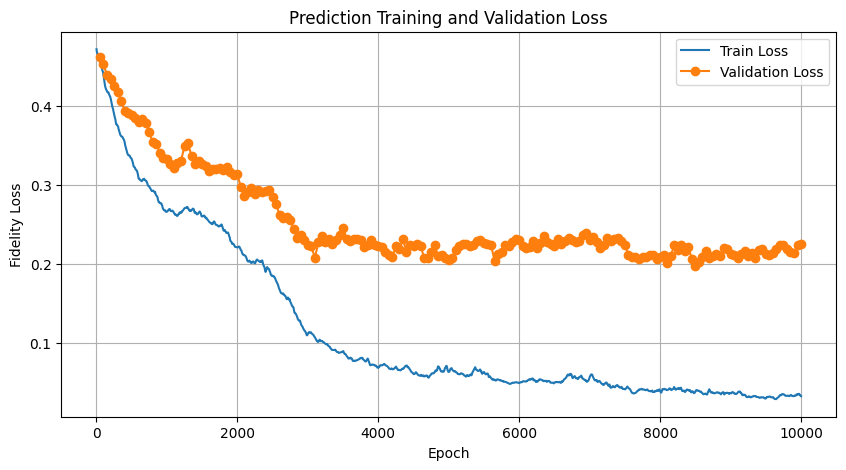

In [59]:
#Train prediction circuit

LEARNING_RATE = 0.01
# We use a large max epoch but rely on early stopping
N_EPOCHS = 10000
PATIENCE = 50  # early-stopping patience (epochs)
MIN_DELTA = 1e-9  # minimum improvement required to reset patience

# How often to evaluate validation loss (in epochs)
VAL_EVAL_EVERY = 50

def init_params():
    """
    Initialize the trainable parameters using torch.nn.Parameter
    """
    n_params_per_layer = len(comp_wires) # 3 input + 1 output = 4
    
    # --- Shared Parameters ---
    # We need L=2 layers of 4 params each
    shared_params = torch.randn(N_LAYERS, n_params_per_layer, 2, requires_grad=True)
    
    # --- Specify Parameters ---
    # We need K=4 sets of (L=2 layers * 4 params each)
    n_stocks = 2**N_CONTEXT_WIRES
    spec_params = torch.randn(n_stocks, N_LAYERS, n_params_per_layer, 2, requires_grad=True)
    
    # We use torch.nn.ParameterDict to keep them organized
    return nn.ParameterDict({
        "shared": nn.Parameter(shared_params),
        "spec": nn.Parameter(spec_params)
    })

#Train the circuit
ss_params = init_params()

ss_optimizer = torch.optim.Adam(ss_params.values(), lr=LEARNING_RATE)

def fidelity_loss(params, key='train'):
    # Run circuit
    y_pred = qmtl_circuit(params, key)

    return 1 - y_pred[0]  # Fidelity loss: 1 - P(0)

print("\n--- Starting Training (with validation monitoring) ---")

# --- Run Epochs (monitor training + validation) ---
train_loss_hist = []
val_loss_hist = []
best_val_loss = float('inf')
epochs_no_improve = 0
# Keep a copy of best params (as detached clones)
best_ss_params = {k: v.detach().clone() for k, v in ss_params.items()}

for epoch in range(N_EPOCHS):
    # Do Quantum Batch Gradient Update (QBGU)
    train_loss = fidelity_loss(ss_params, 'train')

    # Calculate Gradients
    train_loss.backward()

    # Update parameters
    ss_optimizer.step()

    # Clear gradients
    ss_optimizer.zero_grad()

    train_loss_value = train_loss.item()
    train_loss_hist.append(train_loss_value)

    # Periodically evaluate validation loss
    if (epoch + 1) % VAL_EVAL_EVERY == 0 or epoch == N_EPOCHS - 1:
        val_loss = fidelity_loss(ss_params, 'val')

        val_loss_hist.append(val_loss.item())

        # Use validation loss for early stopping
        if val_loss < best_val_loss - MIN_DELTA:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_params = {k: v.detach().clone() for k, v in ss_params.items()}
        else:
            epochs_no_improve += 1

    # Print progress at reasonable intervals
    if (epoch + 1) % VAL_EVAL_EVERY == 0 or epoch == N_EPOCHS - 1:
        val_str = f" - Val: {val_loss:.6f}" if len(val_loss_hist) > 0 else ""
        print(f"Epoch {epoch+1} - Fidelity Loss: {train_loss_value:.6f} - Best Val: {best_val_loss:.6f} - Stalled: {epochs_no_improve}/{PATIENCE}" + val_str)

    # Early stopping based on validation
    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1} (no improvement for {PATIENCE} epochs).")
        break

#save params
torch.save(best_params, 'ss_params.pth')

print("--- Training Complete ---")

# Plot training and validation loss on same figure
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_hist) + 1), train_loss_hist, label='Train Loss')
if len(val_loss_hist) > 0:
    # map val_loss_hist x-axis to the epoch numbers where we evaluated
    val_x = list(range(VAL_EVAL_EVERY, VAL_EVAL_EVERY * len(val_loss_hist) + 1, VAL_EVAL_EVERY))
    # ensure same length
    val_x = val_x[:len(val_loss_hist)]
    plt.plot(val_x, val_loss_hist, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Fidelity Loss')
plt.title('Prediction Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
#load params
sp_params = torch.load('sp_params.pth', weights_only=False)
ss_params = torch.load('ss_params.pth', weights_only=False)

#Plot the final circuit

# 0: Input 1
# 1: Input 2
# 2: Input 3
# 3: Output
# 4: Context 1
# 5: Context 2
# 6: Target 1
# 7: Target 2
# 8: Target 3
# 9: Target 4 (output)
# 10: Ancillary

print(qml.draw(qmtl_circuit)(ss_params))
#print(qml.draw_mpl(qmtl_circuit)(params))

 0: ──H──RY(0.07)───RZ(0.34)──╭●────╭X─────────RY(-0.53)──RZ(-0.04)─╭●────────────╭X──RY(-0.13) ···
 1: ──H──RY(-0.51)──RZ(0.32)──╰X─╭●─│──────────RY(0.16)───RZ(-0.50)─╰X─────────╭●─│───RY(0.02)─ ···
 2: ──H──RY(-0.28)──RZ(0.03)─────╰X─╰●─────────RY(0.22)───RZ(0.53)─────────────╰X─╰●──RY(-0.09) ···
 3: ─────────────────────────────────────────────────────────────────────────────────────────── ···
 4: ──H──RY(-0.63)──RZ(1.76)──╭●─╭X──RY(1.34)──RZ(0.21)──╭●─────────╭X───────────────────────── ···
 5: ──H──RY(0.29)───RZ(-1.06)─╰X─╰●──RY(0.86)──RZ(0.37)──╰X─────────╰●───────────────────────── ···
 6: ──H──RY(0.04)───RZ(0.01)──╭●──────────────╭X──────────RY(-0.26)──RZ(-0.05)─╭●────────────── ···
 7: ──H──RY(-0.20)──RZ(0.10)──╰X─╭●───────────│───────────RY(0.07)───RZ(-0.11)─╰X─╭●─────────── ···
 8: ──H──RY(0.09)───RZ(0.04)─────╰X─╭●────────│───────────RY(-0.43)──RZ(0.05)─────╰X─╭●──────── ···
 9: ──H──RY(0.08)───RZ(-0.05)───────╰X────────╰●──────────RY(0.11)───RZ(0.00)────────╰X──────── ···


# Testing

We run the trained algorithm on the test set classically, one-by-one, to determine accuracy and precision the same way we would with a standard neural network

In [61]:
# Split test windows and prepare quantum states

# Create columns for input and target from each window
df_test['input'] = df_test['window'].apply(lambda x: x[:WINDOW_SIZE-1])  # First 3 entries
df_test['target'] = df_test['window'].apply(lambda x: x[-1])  # Last entry

N_TEST_WIRES = N_CONTEXT_WIRES + N_INPUT_WIRES + N_OUTPUT_WIRES

# Prepare quantum device for input states
dev_test = qml.device("default.qubit", wires=N_TEST_WIRES)

# circuit for testing
@qml.qnode(dev_test)
def test_circuit(features):
    # Prepare input state (should be just X gates)
    qml.BasisState(features, wires=input_wires)

    qml.Barrier(range(N_TEST_WIRES))
    # Prediction circuit (share & specify ansatz)
    ss_ansatz(ss_params, N_LAYERS)

    return qml.probs(output_wires)


In [62]:

# Evaluate on test set
test_results = []

for idx, row in df_test.iterrows():
    # Get input features as a list of integers (0/1)
    input_features = row['input'].tolist()
    
    # Run test circuit
    probs = test_circuit(input_features)
    
    # Predicted class is the one with highest probability
    predicted_class = torch.argmax(probs).item()
    
    test_results.append({
        'context': row['context'],
        'input': input_features,
        'target': row['target'],
        'predicted': predicted_class,
        'probs': probs.detach().numpy()
    })

    if idx % 50 == 0:
        print(f"Processed {idx+1}/{len(df_test)} test samples.")

print(test_results[:5])  # Print first 5 test results

Processed 1/904 test samples.
Processed 51/904 test samples.
Processed 51/904 test samples.
Processed 101/904 test samples.
Processed 101/904 test samples.
Processed 151/904 test samples.
Processed 151/904 test samples.
Processed 201/904 test samples.
Processed 201/904 test samples.
Processed 251/904 test samples.
Processed 251/904 test samples.
Processed 301/904 test samples.
Processed 301/904 test samples.
Processed 351/904 test samples.
Processed 351/904 test samples.
Processed 401/904 test samples.
Processed 401/904 test samples.
Processed 451/904 test samples.
Processed 451/904 test samples.
Processed 501/904 test samples.
Processed 501/904 test samples.
Processed 551/904 test samples.
Processed 551/904 test samples.
Processed 601/904 test samples.
Processed 601/904 test samples.
Processed 651/904 test samples.
Processed 651/904 test samples.
Processed 701/904 test samples.
Processed 701/904 test samples.
Processed 751/904 test samples.
Processed 751/904 test samples.
Processed 80

Accuracy: 0.7699
Recall (weighted): 0.7699

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       350
           1       0.83      0.79      0.81       554

    accuracy                           0.77       904
   macro avg       0.76      0.77      0.76       904
weighted avg       0.77      0.77      0.77       904



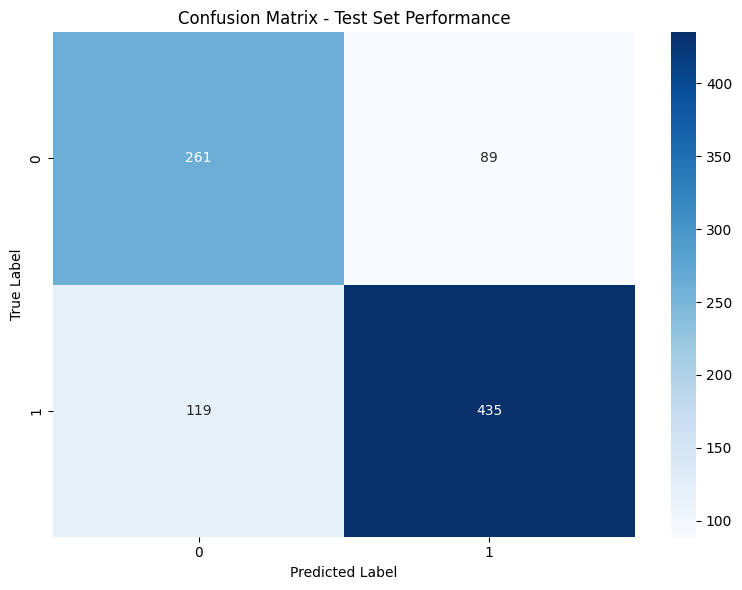


Confusion Matrix:
[[261  89]
 [119 435]]


In [ ]:
# Evaluate model performance

# Extract predictions and targets
y_true = [r['target'] for r in test_results]
y_pred = [r['predicted'] for r in test_results]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set Performance')
plt.tight_layout()
plt.show()

# Print confusion matrix details
print("\nConfusion Matrix:")
print(cm)


PER-CONTEXT PERFORMANCE ANALYSIS

Context AAPL
Samples: 226
Accuracy: 0.7965
Recall (weighted): 0.7965

Confusion Matrix:
[[ 67  20]
 [ 26 113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74        87
           1       0.85      0.81      0.83       139

    accuracy                           0.80       226
   macro avg       0.79      0.79      0.79       226
weighted avg       0.80      0.80      0.80       226


Context GOOGL
Samples: 226
Accuracy: 0.7389
Recall (weighted): 0.7389

Confusion Matrix:
[[ 60  24]
 [ 35 107]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.71      0.67        84
           1       0.82      0.75      0.78       142

    accuracy                           0.74       226
   macro avg       0.72      0.73      0.73       226
weighted avg       0.75      0.74      0.74       226


Context MSFT
Samples: 226
Accuracy: 0.7

PER-CONTEXT PERFORMANCE ANALYSIS

Context AAPL
Samples: 226
Accuracy: 0.7965
Recall (weighted): 0.7965

Confusion Matrix:
[[ 67  20]
 [ 26 113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74        87
           1       0.85      0.81      0.83       139

    accuracy                           0.80       226
   macro avg       0.79      0.79      0.79       226
weighted avg       0.80      0.80      0.80       226


Context GOOGL
Samples: 226
Accuracy: 0.7389
Recall (weighted): 0.7389

Confusion Matrix:
[[ 60  24]
 [ 35 107]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.71      0.67        84
           1       0.82      0.75      0.78       142

    accuracy                           0.74       226
   macro avg       0.72      0.73      0.73       226
weighted avg       0.75      0.74      0.74       226


Context MSFT
Samples: 226
Accuracy: 0.7

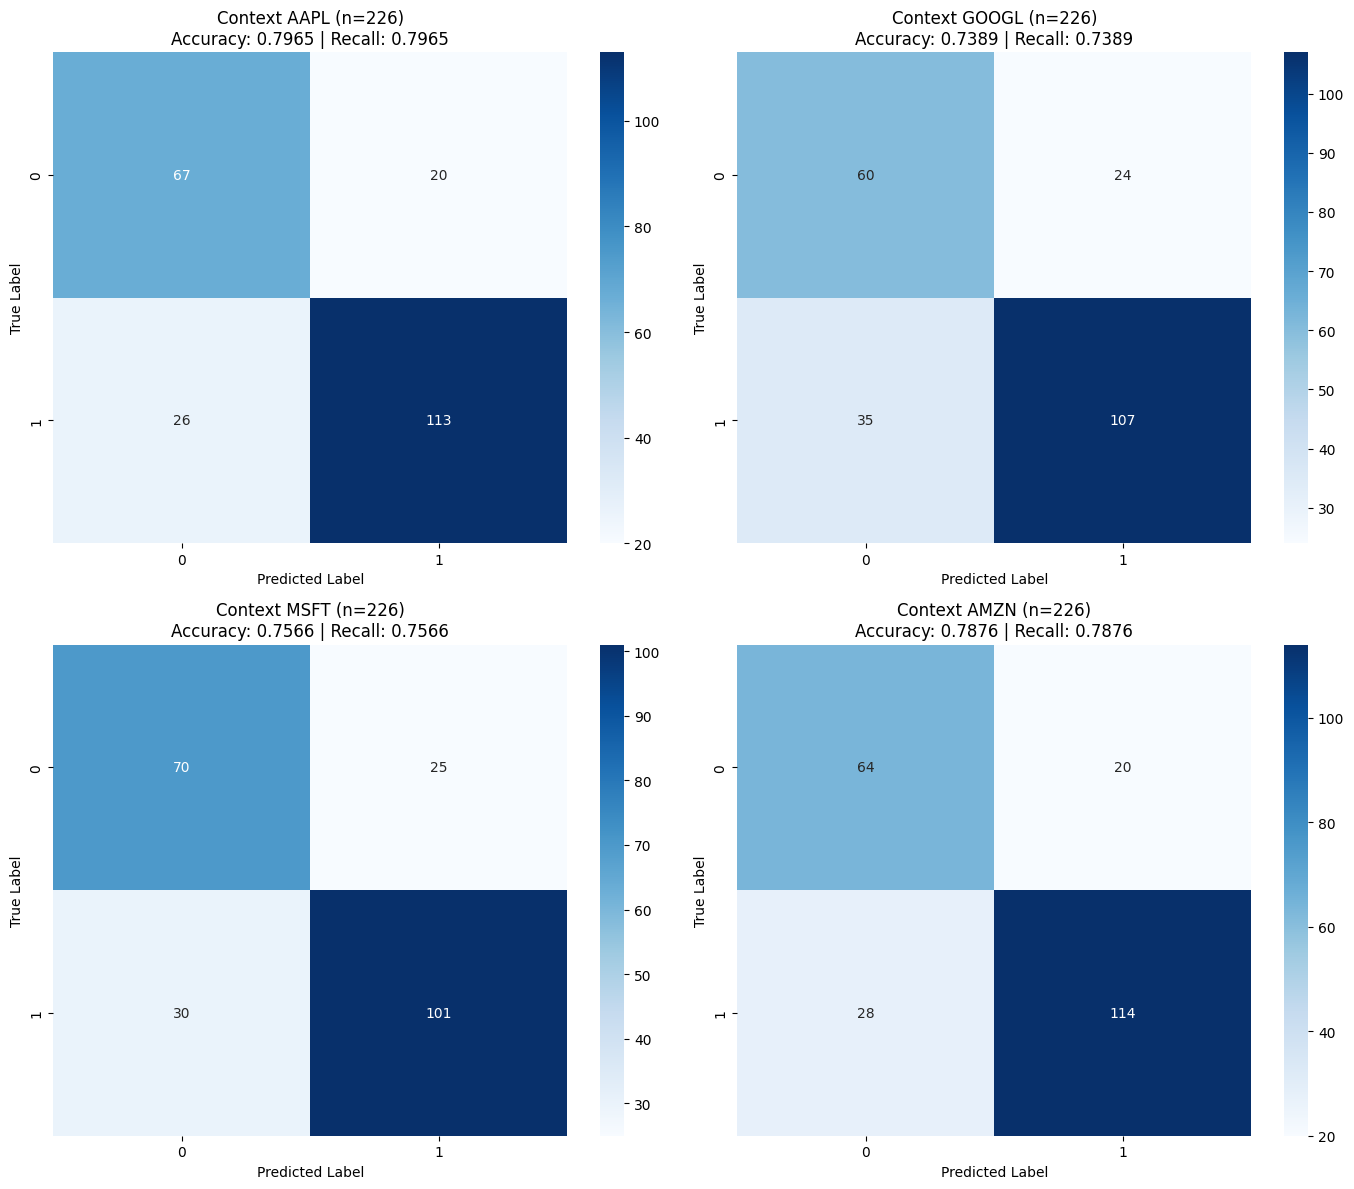


SUMMARY TABLE
  n_samples  accuracy    recall
0       226   0.79646   0.79646
1       226  0.738938  0.738938
2       226  0.756637  0.756637
3       226  0.787611  0.787611


In [74]:
# Compute confusion matrices and metrics for each context
stock_names = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

print("=" * 60)
print("PER-CONTEXT PERFORMANCE ANALYSIS")
print("=" * 60)

# Create a figure with subplots for confusion matrices
n_contexts = int(2 ** N_CONTEXT_WIRES)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

context_metrics = {}

for context_val in sorted(set([r['context'] for r in test_results])):
    # Filter test_results to only samples from this context
    ctx_results = [r for r in test_results if r['context'] == context_val]
    
    # Extract predictions and targets for this context
    y_true_ctx = [r['target'] for r in ctx_results]
    y_pred_ctx = [r['predicted'] for r in ctx_results]
    
    # Calculate metrics
    accuracy_ctx = accuracy_score(y_true_ctx, y_pred_ctx)
    recall_ctx = recall_score(y_true_ctx, y_pred_ctx, average='weighted', zero_division=0)
    
    # Create confusion matrix
    cm_ctx = confusion_matrix(y_true_ctx, y_pred_ctx)
    
    # Store metrics
    context_metrics[context_val] = {
        'accuracy': accuracy_ctx,
        'recall': recall_ctx,
        'confusion_matrix': cm_ctx,
        'n_samples': len(y_true_ctx)
    }
    
    # Plot confusion matrix
    ax = axes[context_val]
    sns.heatmap(cm_ctx, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Context {stock_names[context_val]} (n={len(y_true_ctx)})\nAccuracy: {accuracy_ctx:.4f} | Recall: {recall_ctx:.4f}')
    
    # Print detailed metrics for this context
    print(f"\n{'='*50}")
    print(f"Context {stock_names[context_val]}")
    print(f"{'='*50}")
    print(f"Samples: {len(y_true_ctx)}")
    print(f"Accuracy: {accuracy_ctx:.4f}")
    print(f"Recall (weighted): {recall_ctx:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm_ctx)
    print(f"\nClassification Report:")
    print(classification_report(y_true_ctx, y_pred_ctx, zero_division=0))

plt.tight_layout()
plt.show()

# Summary table of all contexts
print(f"\n{'='*60}")
print("SUMMARY TABLE")
print(f"{'='*60}")
summary_df = pd.DataFrame(context_metrics).T
summary_df = summary_df[['n_samples', 'accuracy', 'recall']]
print(summary_df)


C:\Users\antho\AppData\Local\Temp\ipykernel_29040\3087833260.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


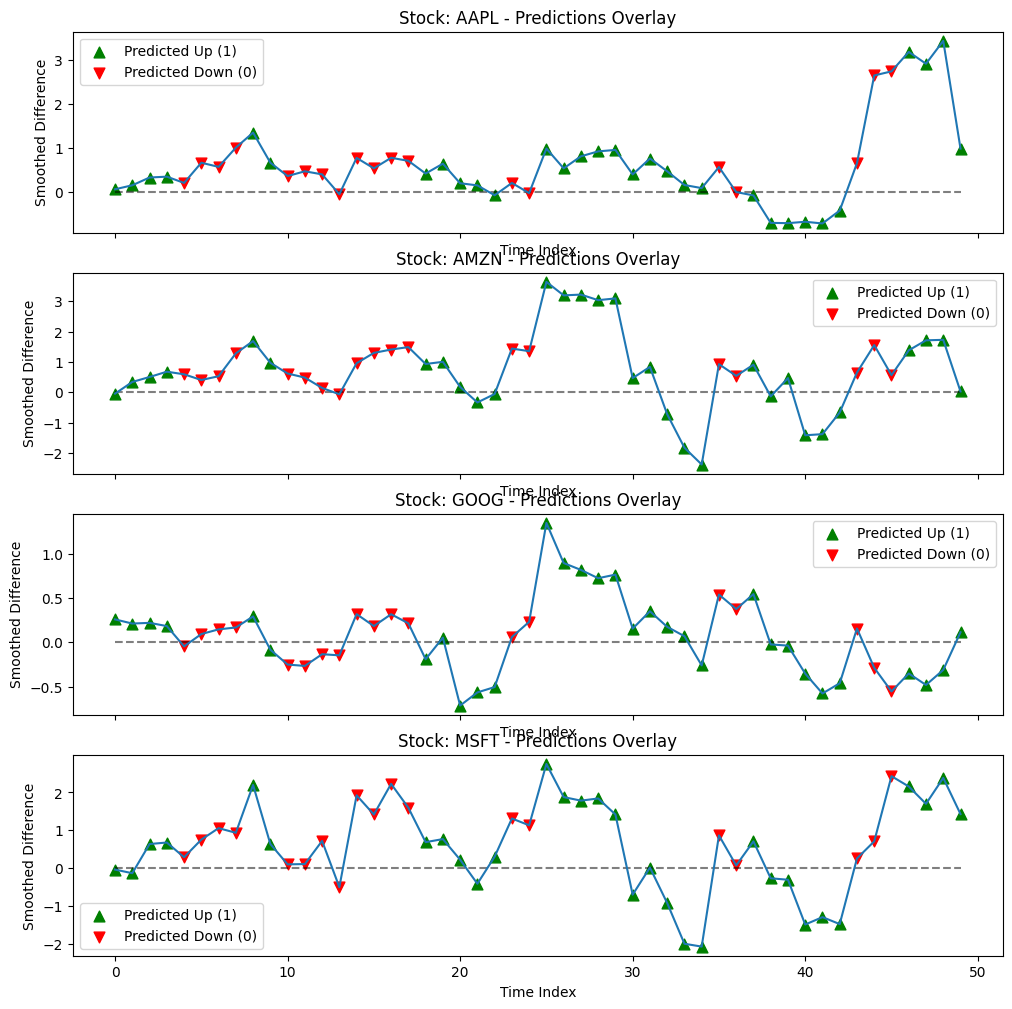

In [90]:
PLOT_NUM = 50

df_diff = pd.read_csv("smoothed_stock_differences.csv")

df_diff = df_diff.iloc[len(df_diff)-len(df_test):].reset_index(drop=True)
df_diff.drop(columns=['Unnamed: 0'], inplace=True)

fig, axes = plt.subplots(len(df_diff.columns), 1, figsize=(12, 3 * len(df_diff.columns)), sharex=True)

df_plot = df_diff[:PLOT_NUM]
test_plot = test_results[:PLOT_NUM]

preds_up = df_plot.iloc[[i for i, r in enumerate(test_plot) if r['predicted'] == 1]]
preds_down = df_plot.iloc[[i for i, r in enumerate(test_plot) if r['predicted'] == 0]]

for i in range(len(axes)):
    ax = axes[i]
    ax.plot(df_plot.index, [0]*len(df_plot), 'k--', alpha=0.5)
    ax.plot(df_plot.index, df_plot.iloc[:, i])
    ax.scatter(preds_up.index, preds_up.iloc[:, i], 
            label='Predicted Up (1)', 
            color='green', 
            marker='^', 
            s=60)

    ax.scatter(preds_down.index, preds_down.iloc[:, i], 
            label='Predicted Down (0)', 
            color='red', 
            marker='v', 
            s=60)
    
    ax.set_title(f'Stock: {df_plot.columns[i]} - Predictions Overlay')
    ax.set_xlabel('Time Index')
    ax.set_ylabel('Smoothed Difference')
    ax.legend()

fig.show()

In [ ]:
print(np.seed)